# Model comparison benchmark analysis

We compare a number of compositional (and non-compositional) models to scCODA's performance on artificial data.
For the data generation parameters and procedure, see the paper or *generate_data*.

We compare the following models:
- scCODA
- Simple Bayesian Dirichlet-Multinomial model
- ALDEx2 (Fernandes et al., 2014)
- ancom (Mandal et al., 2015)
- scDC (Cao et al., 2019)
- dirichReg (Maier, 2014)
- ALR transform and t-test
- ALR transform and Wilcoxon Rank-sum test
- Poisson regression
- t-test

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pickle as pkl
import os

First, we read in the benchmark results and join them into one DataFrame

In [29]:
# Read data
save_path = "../data/model_comparison/model_comparison_new_005/"

total_results = []
sccoda_results = []
simple_dm_results = []
scdc_results = []

for f in os.listdir(save_path):
    with open(save_path + f, "rb") as file:
        r = pkl.load(file)
        if f == "ALDEx2_alr_results.pkl":
            r.loc[:, "model"] = "ALDEx2_alr"
            total_results.append(r)
        elif f.startswith("sccoda"):
            sccoda_results.append(r["results"])
        elif f.startswith("simple_dm"):
            simple_dm_results.append(r["results"])
        elif f.startswith("scdc"):
            scdc_results.append(r)
        else:
            total_results.append(r)

sccoda_results = pd.concat(sccoda_results, ignore_index=True)
simple_dm_results = pd.concat(simple_dm_results, ignore_index=True)
scdc_results = pd.concat(scdc_results, ignore_index=True)

In [30]:
# Join all together
all_res = pd.concat(total_results + [sccoda_results, simple_dm_results, scdc_results], ignore_index=True)

print(all_res)

      n_cell_types n_cells n_controls n_cases Base Increase  \
0                5    5000          8       8  400      200   
1                5    5000          8       8  400      200   
2                5    5000          8       8  400      200   
3                5    5000          8       8  400      200   
4                5    5000          8       8  400      200   
...            ...     ...        ...     ...  ...      ...   
49863            5    5000          9       9  400      400   
49864            5    5000          9       9  400      400   
49865            5    5000          9       9  400      400   
49866            5    5000          9       9  400      400   
49867            5    5000          9       9  400      400   

       log-fold increase                                b_true  \
0                   0.58  [-2.526, -1.47, -1.47, -1.47, -1.47]   
1                   0.58  [-2.526, -1.47, -1.47, -1.47, -1.47]   
2                   0.58  [-2.526, -1.47, -1.

Plotting preparation...

In [31]:
# Get only relevant models for plots
models_rel = ["sccoda", "simple_dm", "scdc", "ancom", "ALDEx2_alr", "alr_ttest", "alr_wilcoxon", "dirichreg", "Haber", "ttest"]
plot_df = all_res.loc[all_res["model"].isin(models_rel)]


In [32]:
# Plotting preparation: Determine linestyles and colors manually
plot_df.loc[:, 'model'] = pd.Categorical(plot_df['model'], models_rel)
plot_df = plot_df.sort_values("model")

linestyles = dict(zip(models_rel, [0, 1, 0, 1, 3, 0, 1, 3, 0, 1]))
colors = dict(zip(models_rel, [0, 0, 1, 1, 1, 2, 2, 2, 3, 3]))

plot_df.loc[:, "linestyle"] = [linestyles[x] for x in plot_df["model"]]
plot_df.loc[:, "color"] = [colors[x] for x in plot_df["model"]]

In [33]:
# Nice label names for legend
leg_labels = ["scCODA", "Simple DM", "scDC", "ancom", "ALDEx2",
              "ALR + t", "ALR + Wilcoxon", "Dirichlet regression", "Poisson regression", "t-test"]
print(leg_labels)

['scCODA', 'Simple DM', 'scDC', 'ancom', 'ALDEx2', 'ALR + t', 'ALR + Wilcoxon', 'Dirichlet regression', 'Poisson regression', 't-test']


Plots of MCC by no. of replicates and effect size. 

We see that sccoda outperforms the other models for low sample sizes and shows comparable performance for higher ones.

The non-compositional models (Poisson regression, t-test) decrease in MCC for large effects due to higher numbers of False Positives.

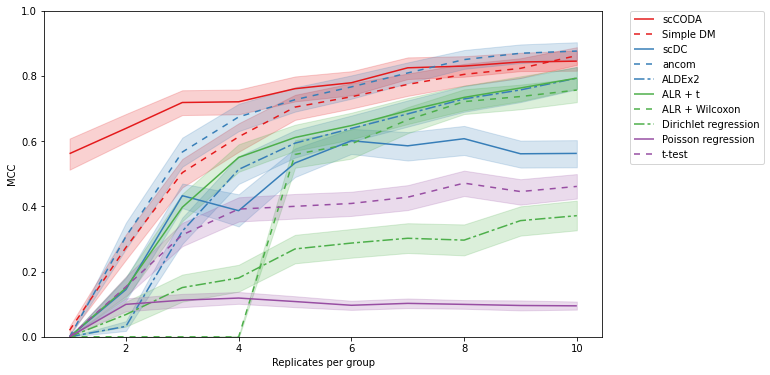

In [34]:
# Plot sample size vs MCC

plot_path = "../data/model_comparison/plots/"
palette = sns.color_palette(['#e41a1c','#377eb8','#4daf4a','#984ea3'])

# Plot for concept fig
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=plot_df, x="n_controls", y="mcc",
             hue="color",
             palette=palette,
             style="linestyle",
             dashes=[(1,0), (4, 4), (7, 2, 2, 2)],
             ax=ax,
             )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           labels=leg_labels
           )
ax.set(xlabel="Replicates per group", ylabel="MCC", ylim=[0,1])

plt.savefig(plot_path + "/model_comparison_replicates_confint_extended.svg", format="svg", bbox_inches="tight")
plt.savefig(plot_path + "/model_comparison_replicates_confint_extended.png", format="png", bbox_inches="tight")

plt.show()

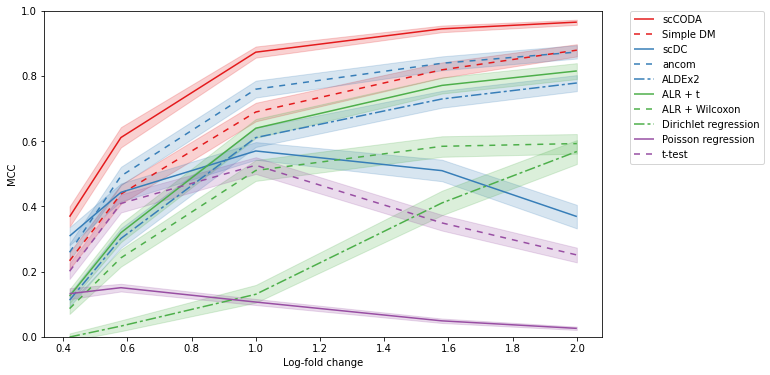

In [35]:
# Plot effect size vs MCC

# Plot for concept fig
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=plot_df, x="log-fold increase", y="mcc",
             hue="color",
             palette=palette,
             style="linestyle",
             dashes=[(1,0), (4, 4), (7, 2, 2, 2)],
             ax=ax,
             )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=leg_labels)
ax.set(xlabel="Log-fold change", ylabel="MCC", ylim=[0,1])

plt.savefig(plot_path + "/model_comparison_logfold_confint_extended.svg", format="svg", bbox_inches="tight")
plt.savefig(plot_path + "/model_comparison_logfold_confint_extended.png", format="png", bbox_inches="tight")

plt.show()


Average MCC for all models: Nothing new here, scCODA performs best on average.

In [36]:
# Avg. mcc for all models:

avg_mcc = all_res.groupby("model").agg({"mcc": "mean"}).sort_values("mcc", ascending=False)
avg_mcc.rename(index={"Haber": "poisson_reg"}, inplace=True)
print(avg_mcc)

                   mcc
model                 
sccoda        0.752169
ancom         0.644547
simple_dm     0.611446
alr_ttest     0.533904
ALDEx2_alr    0.506408
scdc          0.438559
alr_wilcoxon  0.402978
ttest         0.347186
dirichreg     0.228239
poisson_reg   0.092821
